# Estimation de l'ATE/CATE sur des données synthétiques

In [33]:
import numpy as np
from scipy.stats import bernoulli
import scipy as sp
from scipy import stats
from scipy import integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1.5})
plt.rcParams['figure.figsize'] = 10, 8

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install causalml

  Using cached numpy-1.18.5-cp37-cp37m-win_amd64.whl (12.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
    Uninstalling numpy-1.19.2:
      Successfully uninstalled numpy-1.19.2
  Rolling back uninstall of numpy
  Moving to c:\users\arnauda\anaconda3\envs\filrouge\lib\site-packages\numpy-1.19.2.dist-info\
   from c:\users\arnauda\anaconda3\envs\filrouge\lib\site-packages\~umpy-1.19.2.dist-info
  Moving to c:\users\arnauda\anaconda3\envs\filrouge\lib\site-packages\numpy\__config__.py
   from C:\Users\ArnaudA\AppData\Local\Temp\pip-uninstall-2s0p9pwa\__config__.py
  Moving to c:\users\arnauda\anaconda3\envs\filrouge\lib\site-packages\numpy\__init__.cython-30.pxd
   from C:\Users\ArnaudA\AppData\Local\Temp\pip-uninstall-2s0p9pwa\__init__.cython-30.pxd
  Moving to c:\users\arnauda\anaconda3\envs\filrouge\lib\site-packages\numpy\__init__.pxd
   from C:\Users\ArnaudA\AppData\Local\Temp\pip-uninstall-2s0p9pwa\__init__.pxd
  Moving to c:\users\arnauda\anacon

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Accès refusé: 'C:\\Users\\ArnaudA\\anaconda3\\envs\\filrouge\\Lib\\site-packages\\numpy\\.libs\\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



In [34]:
import causalml

## Génération de données

In [35]:
def treatment_assign(Nobs, p):
    '''
    Input: 
    
    p : score de propension.
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    
    Output:
    
    W : Vecteur de taille Nobs contenant des 0 ou 1 pour désigner l'affectation du traitement.
    '''
    W = bernoulli.rvs(p, size = Nobs)
    
    return W

In [36]:
def causal_generation(Nobs, dim, beta, bias, f, g, W):
    '''
    Input :
    
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features).
    beta : Vecteur de dimension (2, dim).
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner l'affectation du traitement.
    f et g sont des fonctions.
    
    Output:
    
    (X, W, Y) : Triplet contenant la matrice X des features, Y le vecteur des résultats potentiels et 
                W le vecteur de l'affectation du traitement.
    '''
    moy = np.zeros(dim)
    var = np.eye(dim)
    X = np.random.multivariate_normal(moy, var, Nobs)
    Y = np.zeros(Nobs)
    
    for i in range(Nobs):
        bruit = np.random.normal(0, 1)
        if W[i] == 0:
            Y[i] = f(beta[0] @ X[i] + bias[0]) + bruit
        if W[i] == 1:
            Y[i] = g(beta[1] @ X[i] + bias[1]) + bruit
            
    return (X, W, Y)

## S-learners

In [37]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SLearner(BaseEstimator, ClassifierMixin):
    """ Homemade SLearner class """
    
    def __init__(self, base_estimator=LinearRegression()):
        # init
        self.estimator = base_estimator
        
    def fit(self, X, W, Y):
        # Initiation des variables
        self.X=X
        self.W=W
        self.Y=Y
        self.features = np.hstack((self.X,self.W[:,np.newaxis]))
        self.clf=self.estimator.fit(self.features,self.Y)

    def predict_CATE(self):
      #ajouter un x en parametre pour calculer le cate sur un point
        # Complete the method         
        self.Y_0_hat=self.clf.predict(np.hstack((self.X,np.zeros(len(self.W))[:,np.newaxis])))
        self.Y_1_hat=self.clf.predict(np.hstack((self.X,np.ones(len(self.W))[:,np.newaxis])))
        return self.Y_1_hat - self.Y_0_hat

    def predict_ATE(self):
        return (self.Y_1_hat - self.Y_0_hat).mean()

## T-learners

In [38]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TLearner(BaseEstimator, ClassifierMixin):
    """ Homemade SLearner class """
    
    def __init__(self, base_estimator0=LinearRegression(), base_estimator1=LinearRegression() ):
        # init
        self.estimator0 = base_estimator0
        self.estimator1 = base_estimator1

    def fit(self, X, W, Y):
        # Initiation des variables
        self.X=X
        self.W=W
        self.Y=Y
        self.mu_0=self.estimator0.fit(X[self.W==0,:],self.Y[self.W==0])
        self.mu_1=self.estimator1.fit(X[self.W==1,:],self.Y[self.W==1])

    def predict_CATE(self):
      #ajouter un x en parametre pour calculer le cate sur un point
        # Complete the method         
        self.Y_0_hat=self.mu_0.predict(self.X)
        self.Y_1_hat=self.mu_1.predict(self.X)
        return self.Y_1_hat - self.Y_0_hat

    def predict_ATE(self):
        return (self.Y_1_hat - self.Y_0_hat).mean()

## X-Learners ( a faire)

## Phase de test ( cas simple)

### Initialisation des paramètres (cas simple)

In [39]:
# paramètres pour faciliter le calcul de l'ATE par intégration
N = 1000
d = 2                                     # d = 2, afin de pouvoir être calculé par intégration et avec Monte Carlo
p = 0.5
beta = np.random.uniform(1, 30, (1, d))
beta = np.vstack((beta,beta))               # beta0 = beta1           
bias = np.array([10,0])                   # Gamma0 = Gamma1 
f = lambda x:x
g = lambda x:np.cos(x)

In [40]:
print(beta, bias)

[[27.98922173  6.65762919]
 [27.98922173  6.65762919]] [10  0]


### Générations des données (cas simple)

In [41]:
# Génération des données
W = treatment_assign(N, p)
X, W, Y = causal_generation(N, d, beta, bias, f, g, W = W)

### Prédictions des métalearners "Team Filrouge"

#### Slearners

In [42]:
slearner=SLearner(base_estimator=LinearRegression())
slearner.fit(X,W,Y)

cate_hat_S = slearner.predict_CATE()
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_S = slearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_S))

- Les dimensions du CATE = (1000,).
- L'estimation de la valeur de l'ATE = -10.132122439970466.


#### Tlearners

In [43]:
tlearner=TLearner(base_estimator0=LinearRegression(),base_estimator1=LinearRegression())
tlearner.fit(X,W,Y)

cate_hat_T = tlearner.predict_CATE()
print("- Les dimensions du CATE = {}.".format(cate_hat_S.shape))

ate_hat_T = tlearner.predict_ATE()
print("- L'estimation de la valeur de l'ATE = {}.".format(ate_hat_T))

- Les dimensions du CATE = (1000,).
- L'estimation de la valeur de l'ATE = -10.111604196403356.


### Prédictions des métalearners "Causal ML"

#### Slearners

In [44]:
from causalml.inference.meta import LRSRegressor
from xgboost import XGBRegressor


lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, W, Y)
print('L\'estimation de la valeur de l\'ATE (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

L'estimation de la valeur de l'ATE (Linear Regression): -10.13 (-11.99, -8.27)


#### Tlearners

In [45]:
from causalml.inference.meta import XGBTRegressor

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, W, Y)
print('L\'estimation de la valeur de l\'ATE (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

L'estimation de la valeur de l'ATE (XGBoost): -10.08 (-11.93, -8.23)


### Paradis

#### Calcul de l'ATE

In [46]:
def ATE_paradis(beta, bias, f=lambda i:i, g=lambda i:i):
  p=beta.shape[1]
  if p==1:
    ate = integrate.quad(lambda x: (g(beta[1]*x + bias[1]) -f(beta[0]*x + bias[0]))*sp.stats.norm.pdf(x,0,1),-1000 , 1000)
  if p==2:
    ate=integrate.dblquad(lambda x, y: (g(beta[1,0]*x + beta[1,1]*y + bias[1]) -f(beta[0,0]*x + beta[0,1]*y + bias[0])
    )*sp.stats.norm.pdf(x,0,1)*sp.stats.norm.pdf(y,0,1),-1000 , 1000, lambda y :-1000,lambda y : 1000)
  if p>2:
    raise Warning('dimension above 2')
  return  ate

In [47]:
def monte_carlo(Nobs, dim, beta, bias, f, g, W):
    '''
    Input :
    
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes.
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features).
    beta : Vecteur de dimension (2, dim), note dim doit être < 10
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner l'affectation du traitement.
    f et g sont des fonctions.
    
    Output:
    
    ATE : ATE calculé par la méthode de Monte Carlo
    '''
    moy = np.zeros(dim)
    var = np.eye(dim)
    X = np.random.multivariate_normal(moy, var, Nobs)
    ATE = np.mean(g(X.dot(beta[1])+ bias[1]) - f(X.dot(beta[0])+ bias[0])) 
            
    return ATE

In [48]:
print('ATE: {}'.format(ATE_paradis(beta, bias, f=f, g=g)))
print('ATE par monte carlo: {}'.format(monte_carlo(10**6, d, beta, bias, f, g, W)))

ATE: (-9.999999991724092, 5.578672355304197e-08)
ATE par monte carlo: -10.057945997666087


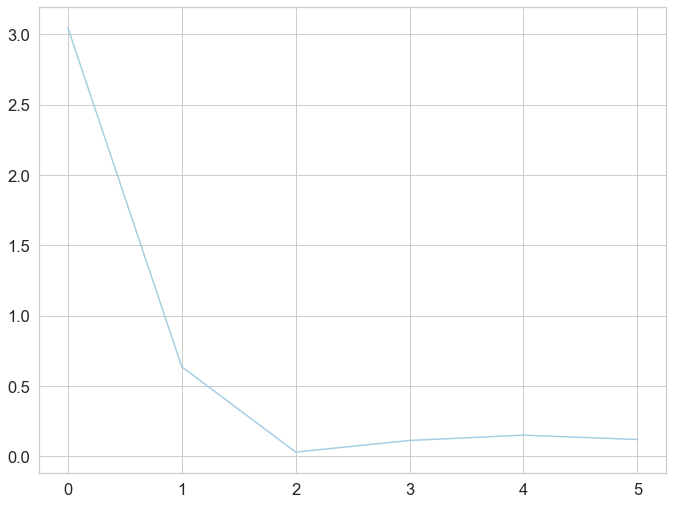

In [49]:
res = []
#1- varier Nobs pour ate_hat_S et le comparer avec mc_est (meth. monte carlo) avec 10**8
#2 - ajouter une courbe avec l'estimation avec causalml avec la borne inf et max et ate_hat_S
for i in range(2,8):
    mc_est = monte_carlo(10**i, d, beta, bias, f, g, W)
    res.append([abs(mc_est - ate_hat_S)])
plt.figure()
plt.plot(res)

#### Calcul des IC

In [50]:
# paramètres pour faciliter le calcul de l'ATE par intégration
N = 1000
d = 2                                     # d = 2, afin de pouvoir être calculé par intégration et avec Monte Carlo
p = 0.5
beta = np.random.uniform(1, 30, (1, d))
beta = np.vstack((beta,beta))               # beta0 = beta1           
bias = np.array([10,0])                   # Gamma0 = Gamma1 
f = lambda x:x
g = lambda x:x

In [51]:
def causal_generation_bootstrap(W, beta, bias, B=999, Nobs=1000, dim=2, f=lambda i:i, g=lambda i:i):
    '''
    Create list of bootstrap elements
    Input :
    
    B : Nombre d'échantillons Boostrap, 999 est une valeur par défaut pertinente
    Nobs : Nombre de lignes da la matrice X i.e. nombre de personnes, 1000 par défaut
    dim : Nombre de colonnes de la matrice X i.e. nombres de caractéristiques (features), 2 par défaut
    beta : Vecteur de dimension (2, dim).
    bias : Vecteur de dimension (1, 2).
    W : Vecteur de dimension (1, Nobs) contenant des 0 ou 1 pour désigner l'affectation du traitement.
    f et g sont des fonctions, identité par défaut
    
    Output:
    
    [(X, W, Y)] : liste de B Triplets contenant la matrice X des features, W le vecteur de l'affectation du traitement et Y
    le vecteur des résultats potentiels. 
                .
    '''
    Bootstraps=[]
    
    for b in range(B):
        Bootstraps.append(causal_generation(Nobs, dim, beta, bias, f, g, W = W))
      
    return Bootstraps

In [52]:
def IC(Bootstraps, base_metalerner=SLearner(),alpha=0.05):
    
    '''
    Calculate l'intervalle de confiance d'un métalearner
    
    Input :
    
    Bootstraps : Liste d'échantillons Boostraps comprenant B triplets (X,Y,W)
    base_metalerner : metalearner à évaluer
    
    Output:
    
    IC : (IC inf , IC sup) du métalearner 
    '''
    #import
    from scipy.stats import norm
    
    #Calcul de l'ATE les B estimateurs du Bootstrap
    ATEs=np.zeros((len(Bootstraps)))
    base_metalearner=SLearner()
    for i in range(len(Bootstraps)):
        base_metalearner.fit(Bootstraps[i][0],Bootstraps[i][1],Bootstraps[i][2])
        base_metalearner.predict_CATE()
        ATEs[i]=base_metalearner.predict_ATE()
    
    #Calcul des intervalles de confiance
    Mu_ATEs= ATEs.mean()
    std_ATEs= ATEs.std()
    ATEs_tilt= (ATEs-Mu_ATEs)/std_ATEs
    ATEs_tilt.sort()
    ATEs.sort()
    IC_inf, IC_sup = ATEs[int(B*(alpha/(2)))], ATEs[int(B*(1-alpha/(2)))]
    
    return (Mu_ATEs, IC_inf, IC_sup)

In [53]:
N=100
B=999
W = treatment_assign(N, p)
Bootstraps=causal_generation_bootstrap(W, beta, bias, B=B, Nobs=N, dim=2, f=lambda i:i, g=lambda i:i)
IC(Bootstraps, base_metalerner=SLearner(),alpha=0.05)

(-9.995309839266966, -10.400539701435896, -9.563981345003397)

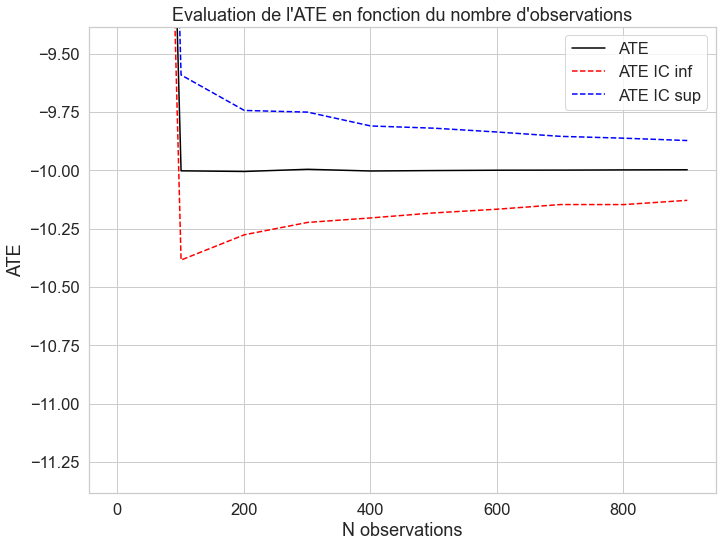

In [54]:
ates = []
ates_inf = []
ates_sup = []
B=999
for i in range(1,1000,100):
    W = treatment_assign(i, p)
    Bootstraps=causal_generation_bootstrap(W, beta, bias, B=B, Nobs=i, dim=2, f=lambda i:i, g=lambda i:i)
    mu, inf, sup = IC(Bootstraps, base_metalerner=SLearner(), alpha=0.05)
    ates.append(mu)
    ates_inf.append(inf)
    ates_sup.append(sup)

plt.figure(figsize=(10,8))
x=np.arange(1,1000,100)
plt.plot(x, ates, color='k',label='ATE')
plt.plot(x, ates_inf, '--', color='r',label='ATE IC inf')
plt.plot(x, ates_sup, '--', color='b',label='ATE IC sup')
plt.ylim(min(ates_inf)-1,min(ates_inf)+1)
plt.xlabel("N observations")
plt.ylabel("ATE")
plt.title("Evaluation de l'ATE en fonction du nombre d'observations")
plt.legend(loc=1,numpoints=1)

plt.show();